# CNN visualization of intermediate steps using Saliency maps 

Using TensorFlow 2.0 and Keras

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import activations, datasets, layers, losses, metrics, models, optimizers, regularizers
import tensorflow as tf
import seaborn as sns

In [2]:
if True:
    import os
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Data - CIFAR-10

Images are normalized to $[0, 1]$

In [3]:
(xTrain, yTrain),(xTest, yTest) = datasets.cifar10.load_data()
xTrain = xTrain / 255.
xTest  = xTest  / 255.

classNames = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

xTrain.shape, xTest.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

# Model

In [4]:
model0 = models.load_model('models/CIFAR-10_CNN5.h5')
model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

# Helpers

In [271]:
def predictUntilLayer(model, layerIndex, data):
    """ Execute prediction on a portion of the model """
    intermediateModel = models.Model(inputs=model.input,
                                 outputs=model.layers[layerIndex].output)
    return intermediateModel.predict(data)

def plotHeatMap(X, classes='auto', title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None,
               vmin=None, vmax=None, cbar=True):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, 
                     fmt=fmt, vmin=vmin, vmax=vmax, cbar=cbar, cmap=plt.cm.bwr, ax=ax) 
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotOutputs(numConvo, numCols, samples, originals, labels):
    """ Plot a layer output on selected samples """
    numRowsPerSample = int(np.ceil(numConvo / numCols))
    numRows = len(originals) * numRowsPerSample
    fig, axes = plt.subplots(numRows, numCols + 1, figsize=((numCols + 1) * 2, numRows * 2))
    axes = axes.ravel()
    for i, sample in enumerate(samples):
        ax = axes[i * (numRowsPerSample * (numCols + 1))]
        ax.imshow(originals[i])
        ax.set_title(labels[i])
        if(i == 0): 
            ax.xaxis.tick_top()
        for row in range(numRowsPerSample):
            for col in range(numCols):
                c = row * numCols + col
                ax = axes[(i * numRowsPerSample + row) * (numCols + 1) + col + 1]
                ax.imshow(samples[i,:, :, c], cmap='gray')
                ax.set_title('Conv #' + str(c))
                if(i == 0): 
                    ax.xaxis.tick_top()
    plt.setp(axes, xticks=[], yticks=[], frame_on=False)
    
def plotSaliencyMap(original, saliencies, layerNames, dimensions = (32, 32, 3), originalClass=None):
    """ Plot saliency map and comparison to input """
    n = len(saliencies)
    fig, axes = plt.subplots(n, 3, figsize=(16, 4*n))
    axes[0][0].imshow(original.reshape(dimensions))
    axes[0][0].set_title("Input")
    if originalClass is not None:
        axes[0][0].set_xlabel(originalClass)
    for i in range(n):
        axes[i][1].imshow(saliencies[i].reshape(dimensions))
        axes[i][1].set_title("%s Saliency" % layerNames[i])
        axes[i][2].imshow(np.clip((saliencies[i] - original).reshape(dimensions), 0, 1))
        axes[i][2].set_title("Saliency - Input")
    plt.setp(axes, xticks=[], yticks=[], frame_on=False)

# Convolution layer #0 activation

Convolution layer #0 is connected to the 32x32, single channel image input. There are 6 convolutions in this layer.

Let's draw the layer's convolution units' coefficients as heat maps:

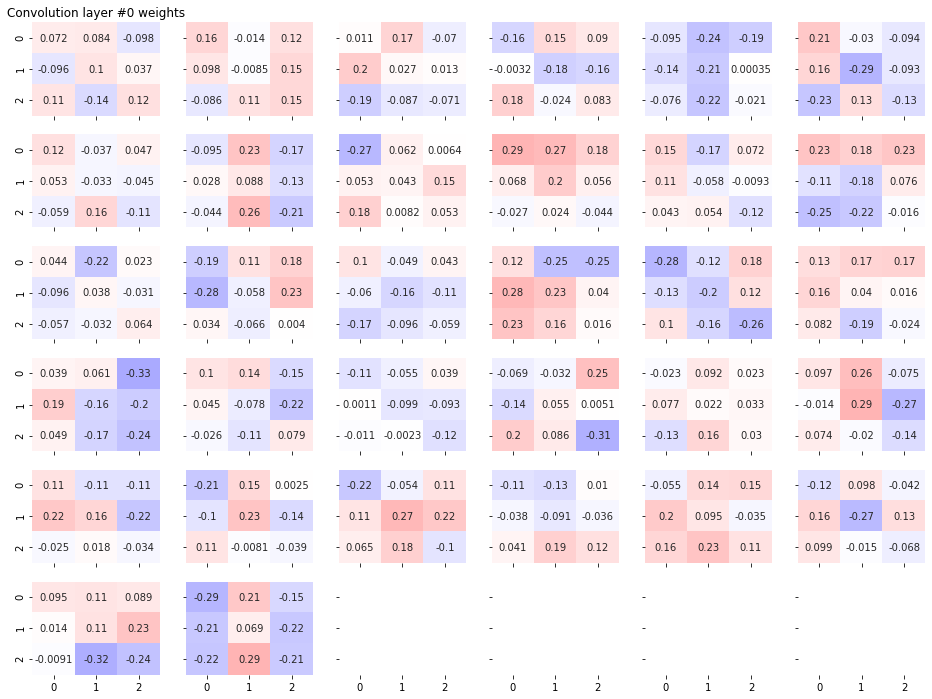

In [270]:
weights0 = model0.get_weights()

fig, axes = plt.subplots(6, 6, figsize=(16, 12), sharex=True, sharey=True)
for i in range(32):
    ax = axes.ravel()[i]
    plotHeatMap(weights0[0][:,:, 0, i], [0, 1, 2], ax=ax, vmin=-1., vmax=1., cbar=False)

axes[0,0].set_title("Convolution layer #0 weights");
plt.setp(axes, frame_on=False);

It is quite difficult to extract information from that many displays with so many figures.

It is also difficult to evaluate the impact of each neuron unit given the connections to previous and following layers.

## Sample set to compute activations

Above display of weights is limited in useful information about the network.

Many visualization technics are using some sample set of images to inspect the activations within the network

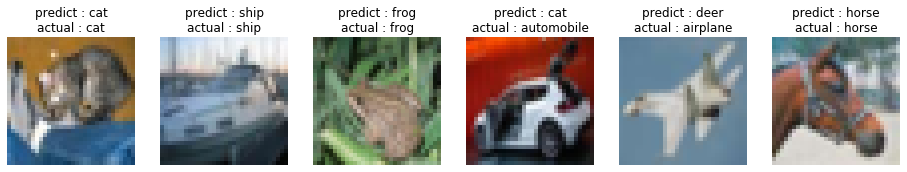

In [274]:
selectedSampleIndexes = [0,2,4,6,10,17]
selectedSamples = xTest[selectedSampleIndexes]
selectedLabels = [classNames[yTest[i][0]] for i in selectedSampleIndexes]
preds = np.argmax(model0.predict(selectedSamples), axis=1)
selectedPredictions = [classNames[p] for p in preds]

fig, axes = plt.subplots(1, len(selectedSampleIndexes), figsize=(16, 7))
for ax, sample, estLabel, trueLabel in zip(axes, selectedSamples, selectedPredictions, selectedLabels):
    ax.imshow(sample)
    ax.set_title("predict : %s\nactual : %s" % (estLabel, trueLabel))
plt.setp(axes, xticks=[], yticks=[], frame_on=False);

Note the horse on the right is wrongly labeled dog by the classifier.

In [9]:
sampleAtLayer0 = predictUntilLayer(model0, 0, selectedSamples)
sampleAtLayer0.shape

(6, 30, 30, 32)

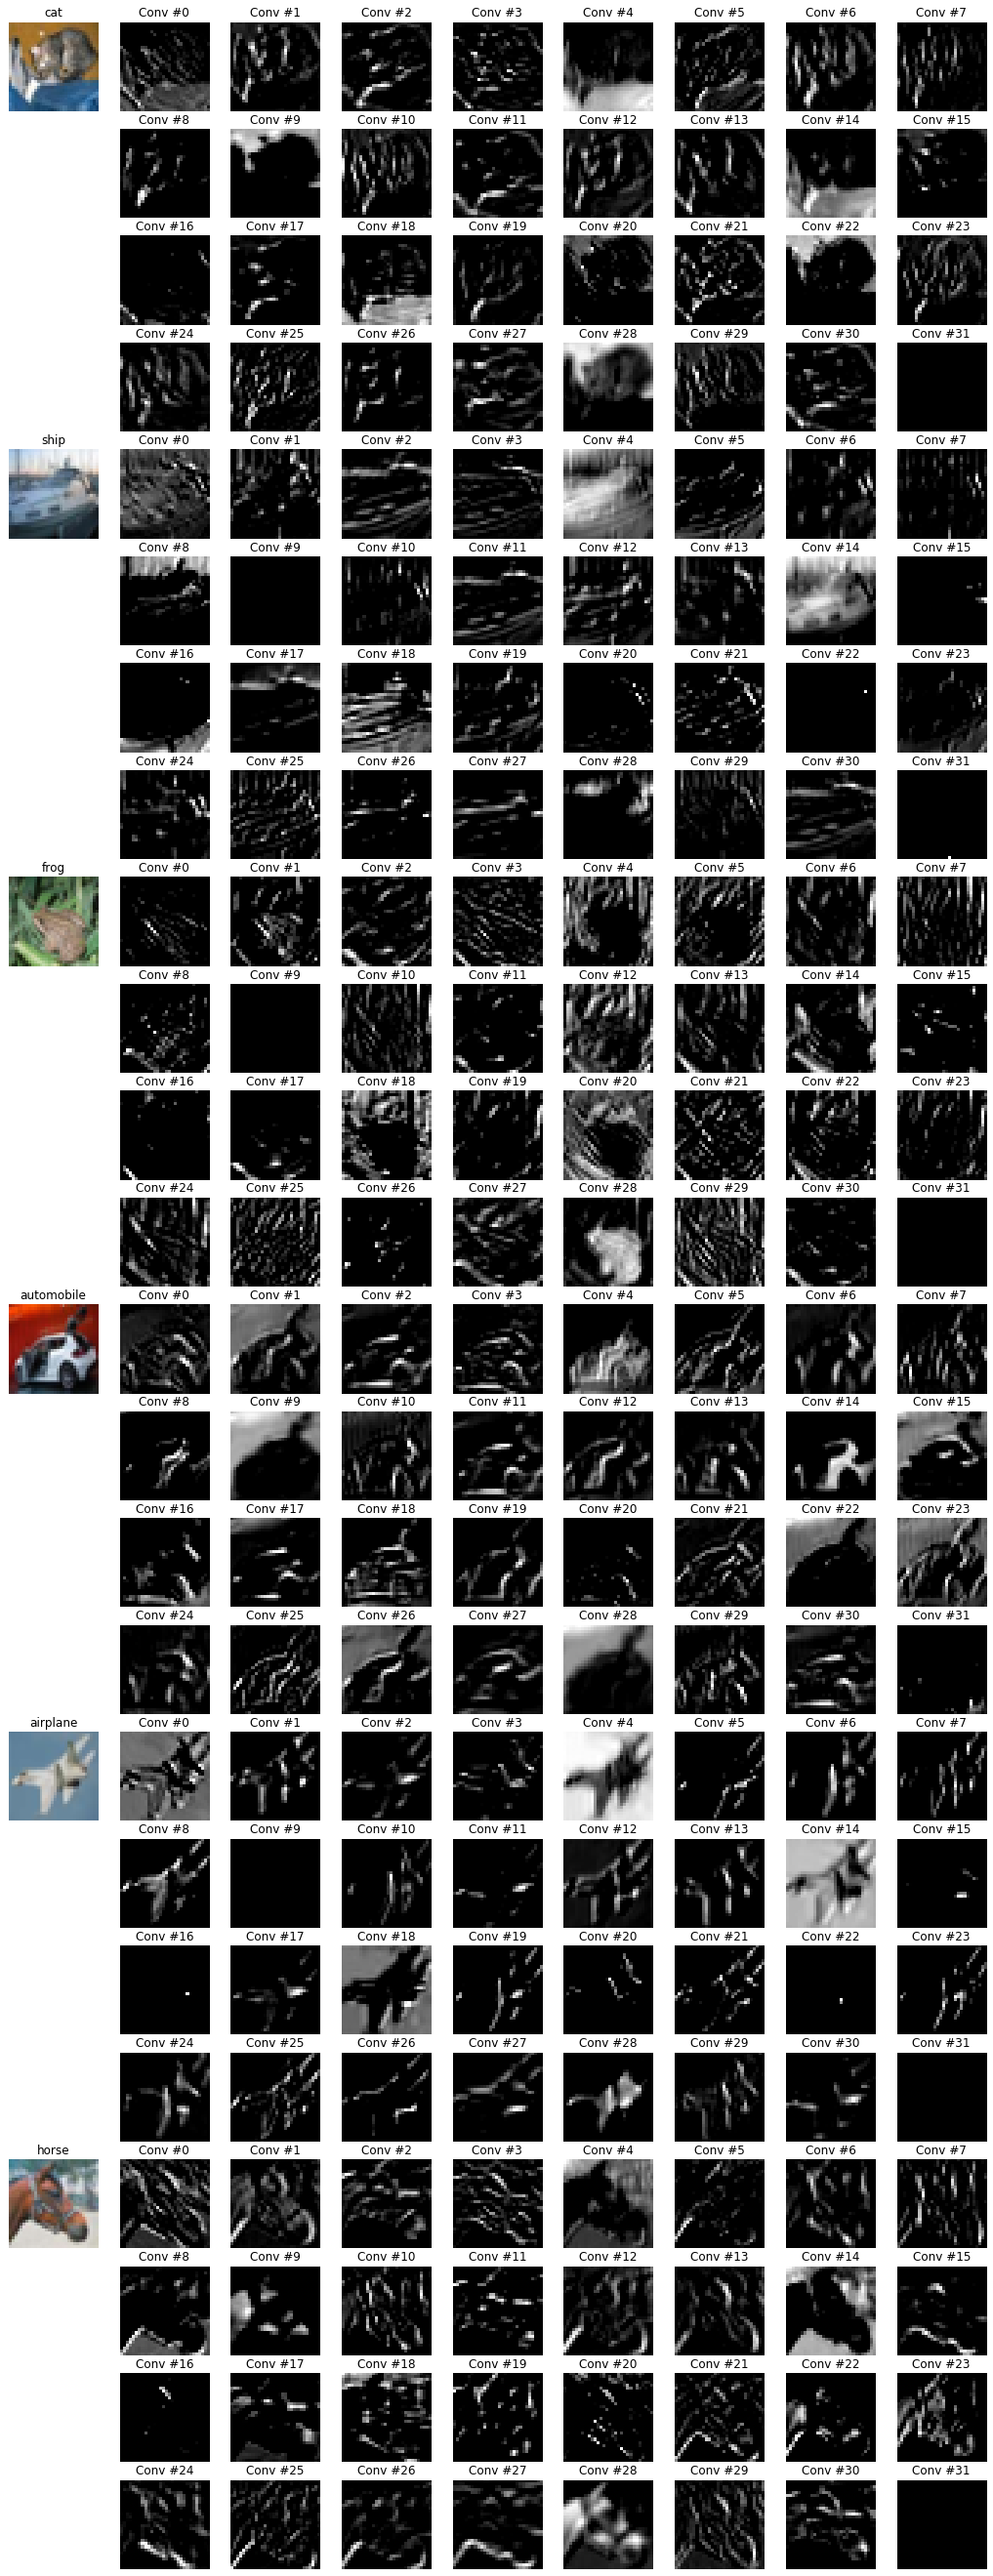

In [272]:
plotOutputs(32, 8, sampleAtLayer0, selectedSamples, selectedLabels)

We may observe that some neurons are focusing on edges like #3, #4, #8

Here again, the information load is high.

## Layer #0 dropout activations

In [11]:
sampleAtLayer0drop = predictUntilLayer(model0, 1, selectedSamples[0:2])
sampleAtLayer0drop.shape

(2, 15, 15, 32)

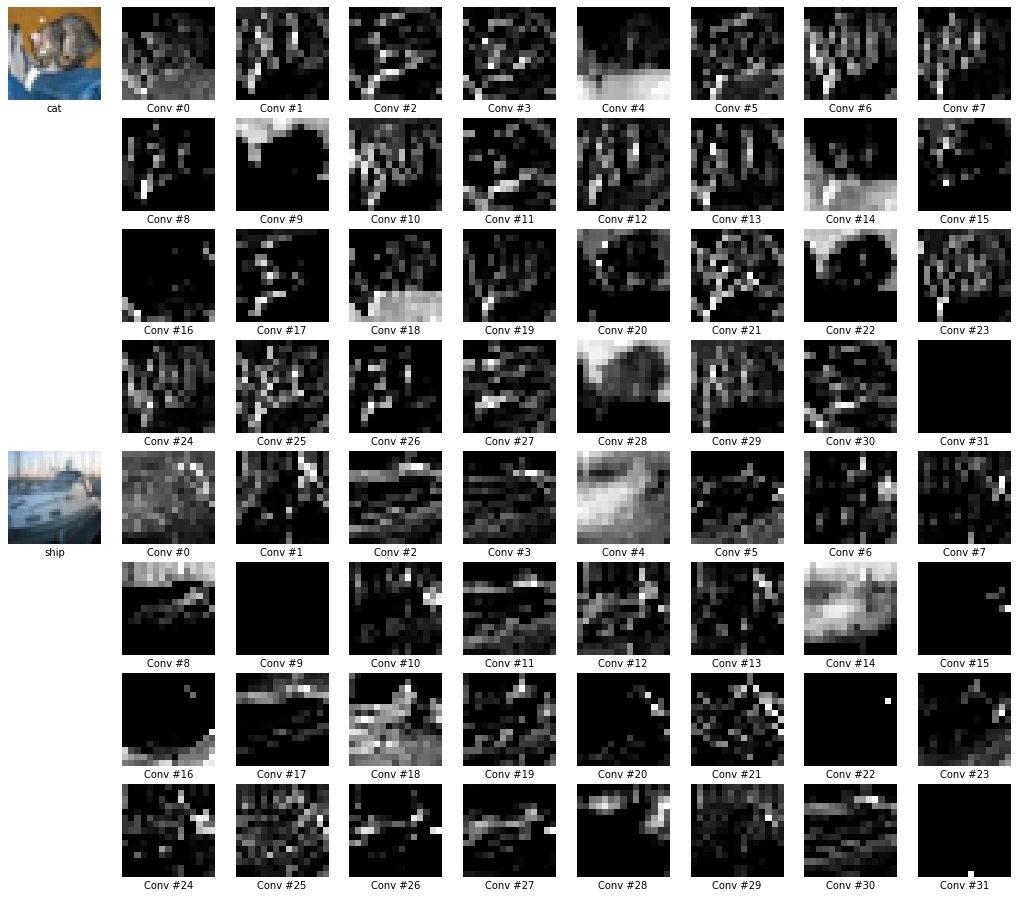

In [12]:
plotOutputs(32, 8, sampleAtLayer0drop, selectedSamples[0:2], selectedLabels[0:2])

As expected, the average drop out is acting as a low pass filter and a downsampler.

# Convolution layer #1 activation

Convolution layer #1 is connecter to the #0 by an average pooling 2x2 (halving the size of the image on each of the 2 dimensions). It is made of 64 convolutions connected to each of the 6 inputs.

In [13]:
weights0[2].shape

(3, 3, 32, 64)

In [14]:
sampleAtLayer1 = predictUntilLayer(model0, 2, selectedSamples)
sampleAtLayer1.shape

(6, 13, 13, 64)

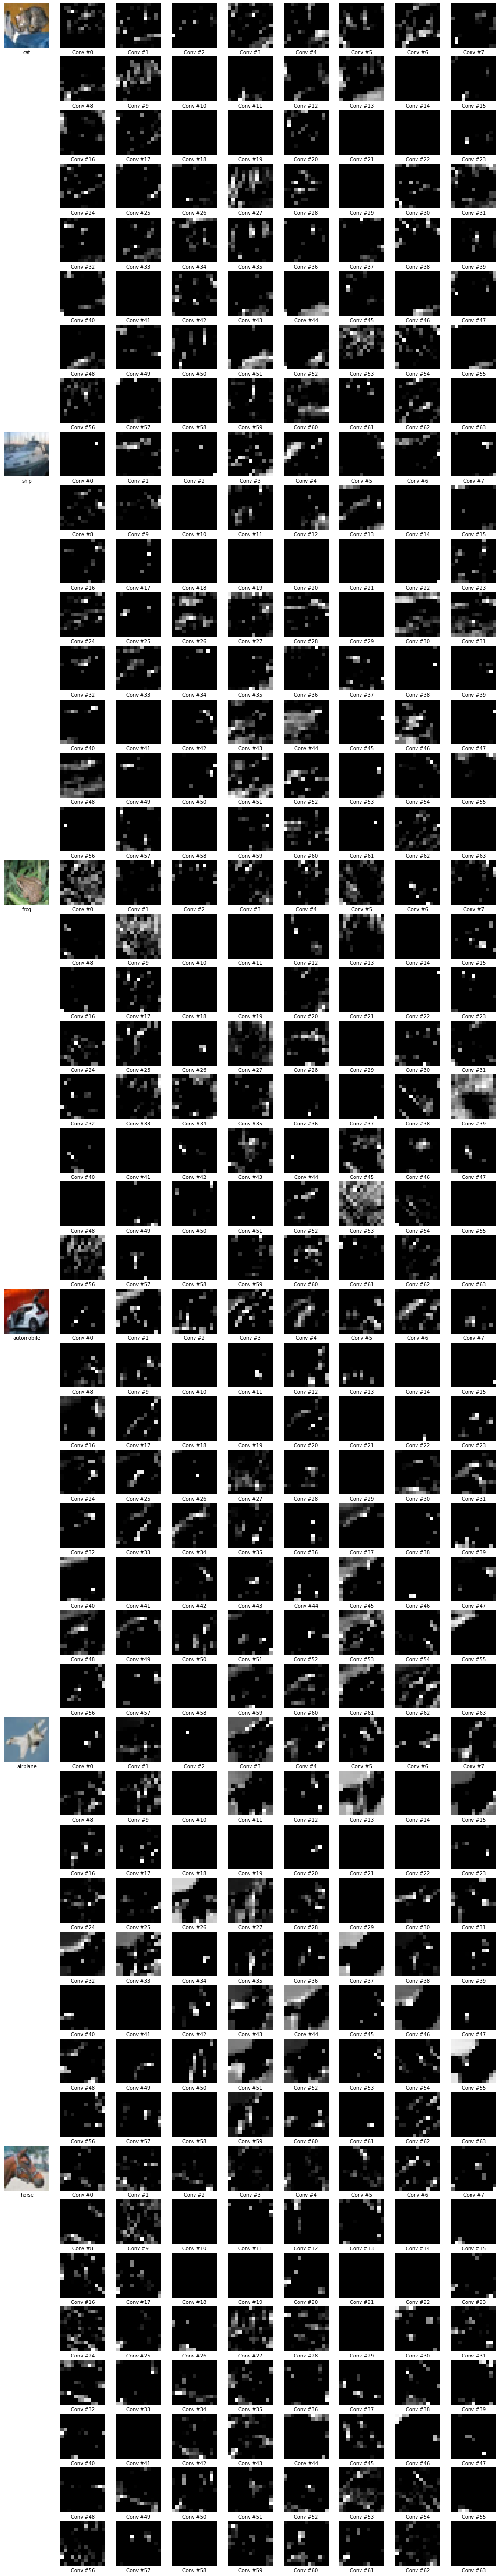

In [15]:
plotOutputs(64, 8, sampleAtLayer1, selectedSamples, selectedLabels)

We see that at the output of the second convolutional layer, the filters are focusing on some more detailed par of the digits. But it is becomes harder to exactly state what is the focus of each filter.

The jet plane with its very sharp edges is the easiest to read out as the edges appear on some of the filters' activations.

# Saliency maps

Original saliency map paper [2, section 3] called it "Activation maximization". Activation is reinforced through gradient ascent in order to maximize :
$$ x^* = \arg \max_{x s.t. \Vert x \Vert = \rho} h_{ij}(θ,x)$$

In which : 
- $h_{ij}$ is the unit #j of the layer #i
- $x$ is element of the image space ($\in \mathbb{R}^p \times \mathbb{R}^q$, p and q being the width and height)
- $\theta$ are the coefficients of the unit

This problem is very difficult to tackle with a numerical optimizer.

A sub-optimal solution is sought through gradient ascent. As explained in [3, section 3], this corresponds to a first degree Taylor expansion evaluated at the current image.

In [2], gradient ascent is performed 9 times on random picked test samples.

In [3] the saliency maps is computed only on a modified softmax layer in order to compute the best activation for a given class. The image is initialized with a neutral image (medium grey or black).

Following code is inspired by [4] but using Keras and TensorFlow 2.0, and from the Deepdream demo of TensorFlow [5] but without the strange combination of two layers, without the clip on the image pixel values that is inserting some high frequency noise (ripples).

In [304]:
@tf.function
def gradientStep(model, img, learningRate, lambdaReg, trueActivation): #, optimizer)
    if trueActivation is None:
        with tf.GradientTape() as tape:
            tape.watch(img)
            activation = model(img) 
            intensity = tf.math.reduce_mean(activation)
        grads = tape.gradient(intensity, img)
    else:
        with tf.GradientTape() as tape:
            tape.watch(img)
            tape.watch(trueActivation)
            activation = model(img) 
            intensity = tf.math.multiply(trueActivation, activation)
        grads = tape.gradient(intensity, img)
    
    # Gradient ascent
    #optimizer.apply_gradients(zip(grads, img))
    img = img + learningRate * grads - lambdaReg * tf.norm(img, 'euclidean', axis=(1, 2)) #fro
    return intensity, grads, img

def getSalient(numEpochs, model, img, learningRate, lambdaReg, trueActivation=None):
    
    imgTf = tf.expand_dims(img, axis=0)
    if trueActivation is not None:
        trueActivationTf = tf.constant(trueActivation.reshape(1, -1))
    else:
        trueActivationTf = None
        
    #optimizer = optimizers.Adam()
    intensityHist, gradHist = [], []
    
    for epoch in range(numEpochs):
       
        intensity, grads, imgTf = gradientStep(model, imgTf, learningRate, lambdaReg, trueActivationTf) #, optimizer)
        
        intensityHist.append(intensity)
        gradHist.append(grads)
    
    # Only clip the returned saliency image
    return (tf.clip_by_value(imgTf, 0, 1)[0], intensityHist, gradHist)

Apply on neutral grey image

In [311]:
mediumGray = np.ones((32, 32, 3)) * 0.5
globalSaliencies = []

for c in range(10):
    trueActivation = np.zeros(10, dtype=np.float32)
    trueActivation[c] = 1

    globalSaliencies.append(getSalient(300, model0, mediumGray, 2, 1e-5, trueActivation))

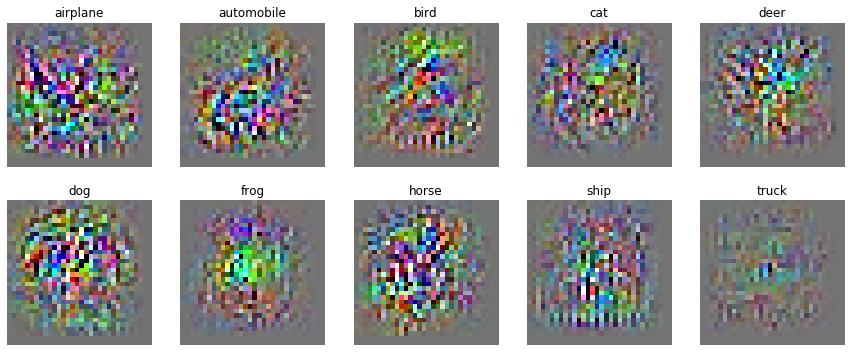

In [312]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for c, sal, ax in zip(classNames, globalSaliencies, axes.ravel()):
    ax.imshow(sal[0].numpy()) 
    ax.set_title(c)
plt.setp(axes, xticks=[], yticks=[], frame_on=False);

## Selected image saliency

Another way to use saliency maps is to select some test image samples and perform the same gradient ascent. The main interest is to visualize not only the parts of the images that activate the full network but also the ones that activate part of the network.

In [329]:
layerTitles = ['Conv layer #0', 'Conv layer #1', 'Conv layer #2', 'Dense layer #0']
partialModels = [models.Model(inputs=model0.input,
                      outputs=model0.layers[i].output) for i in [0, 2, 4, 7]]

testImgIndex =  17
sampleInput = xTest[testImgIndex]
saliencyRes = []
for m, learningRate in zip(partialModels, [2, 1, 0.1, 0.02]):
    saliencyRes.append(getSalient(1000, m, sampleInput, learningRate, learningRate / 5e5))

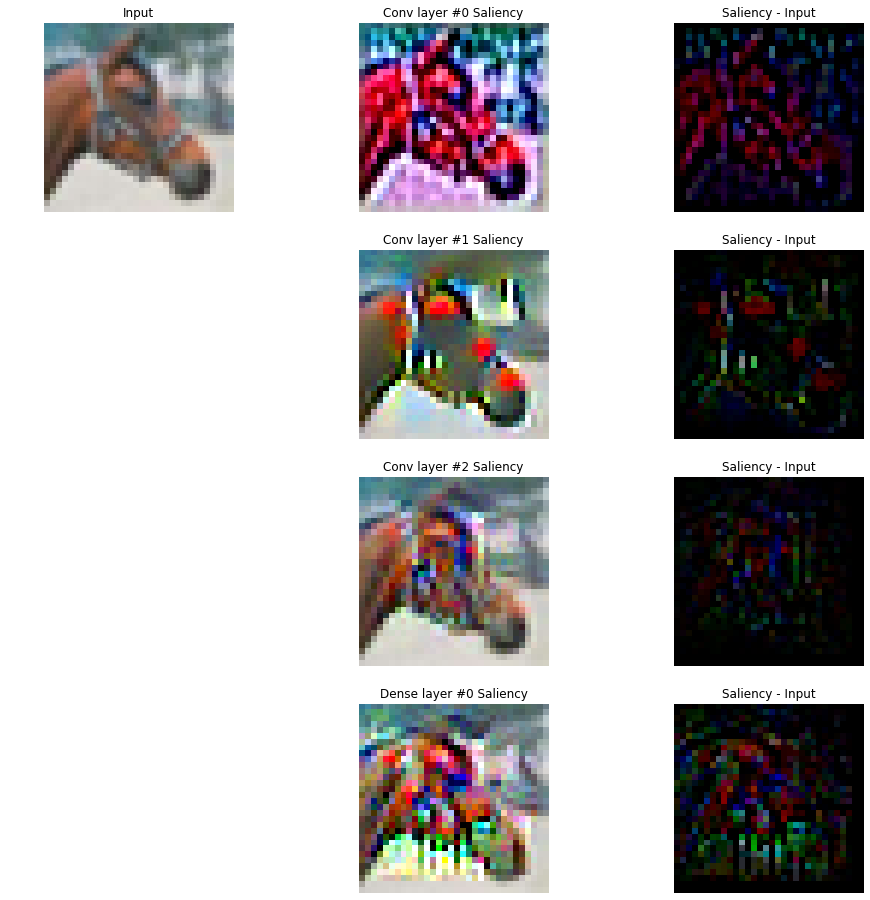

In [330]:
plotSaliencyMap(sampleInput, 
                [saliencyRes[i][0].numpy() for i in range(len(saliencyRes))], 
                layerTitles)

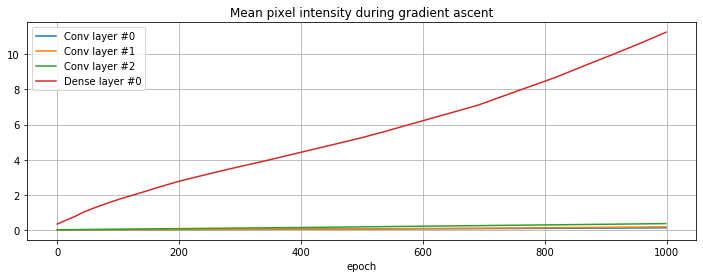

In [331]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
for i in range(len(saliencyRes)):
    ax.plot(saliencyRes[i][1], label=layerTitles[i])
ax.set_title('Mean pixel intensity during gradient ascent')
ax.set_xlabel('epoch')
ax.legend()
ax.grid()

The pixel values are clipped at the end of the saliency processing to $[0,1]$

In [157]:
np.min(saliencyRes[2][2][90].numpy()), np.max(saliencyRes[2][2][90].numpy())

(-0.010291116312146187, 0.012279173359274864)

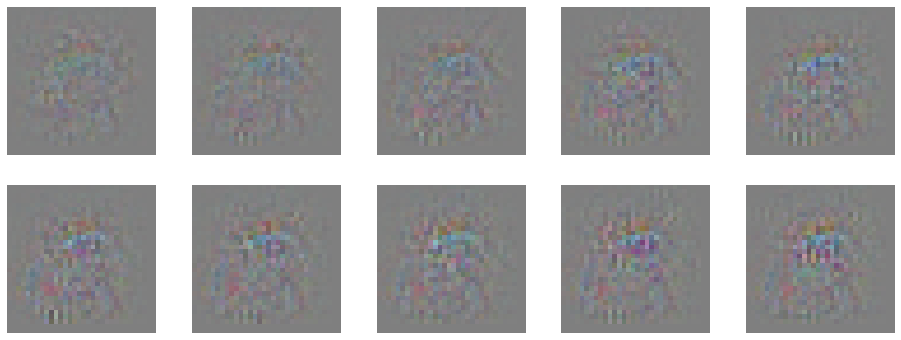

In [158]:
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow((saliencyRes[2][2][10 * i].numpy() * 20 + 0.5).reshape(32, 32, 3))
plt.setp(axes, xticks=[], yticks=[], frame_on=False);

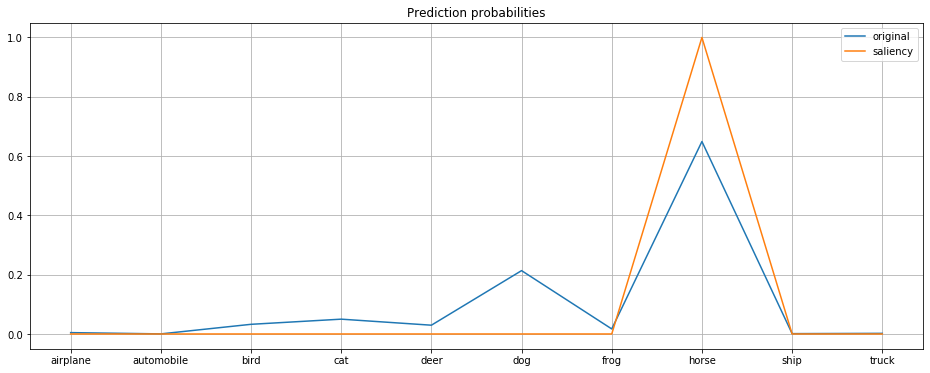

In [167]:
predictions = model0.predict(np.array([sampleInput, saliencyRes[3][0].numpy()]))

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.plot(predictions[0], label='original')
ax.plot(predictions[1], label='saliency')
ax.set_title('Prediction probabilities')
ax.set_xticks(range(10), minor=False)
ax.set_xticklabels(classNames, minor=False)
ax.legend()
ax.grid()

## References

1. [Tensorflow tutorial for CNN](https://www.tensorflow.org/tutorials/images/cnn)
2. [Visualizing Higher-Layer Features of a Deep Network, D. Erhan, Y. Bengio, A. Courville, 2009](https://www.researchgate.net/publication/265022827_Visualizing_Higher-Layer_Features_of_a_Deep_Network)
3. [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/pdf/1312.6034.pdf)
4. [Saliency Maps for Deep Learning Part 1: Vanilla Gradient, Andrew Schreiber](https://medium.com/@thelastalias/saliency-maps-for-deep-learning-part-1-vanilla-gradient-1d0665de3284)
5. [DeepDream, Tensorflow documentation](https://www.tensorflow.org/tutorials/generative/deepdream)